##### Import

In [28]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

In [29]:
# from pathlib import Path
# import pandas as pd
# from utils import rank_stocks_and_quantile
# # UNSEEN_KEY = '/data/YEAR_20220803_20230803'
# top = 250  # parameters -> papermill
# DATA_STORE = Path(f'data/{top}_dataset.h5')
# with pd.HDFStore(DATA_STORE) as store:
#     # unseen = store[UNSEEN_KEY]
#     print(store.keys())

In [30]:
from utils import rank_stocks_and_quantile

top = 250 # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_key = '/data/YEAR_20200930_20220802'
# dataset_key = None
# target = 'TARGET_ret_fwd_frac_order' #'TARGET_ret_fwd_01d' #'TARGET_ret_fwd_frac_order'
target = 'TARGET_ret_fwd_01d' 
with pd.HDFStore(DATA_STORE) as store:
    dataset = store[dataset_key]
    # dataset = store['/data/YEAR_20161115_20181022']
    dataset = rank_stocks_and_quantile(dataset, TARGET_col=target)

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117250 entries, (Timestamp('2020-09-30 00:00:00+0000', tz='UTC'), 'AA') to (Timestamp('2022-08-02 00:00:00+0000', tz='UTC'), 'ZTS')
Columns: 600 entries, FEATURE_open to TARGET_ret_fwd_01d_rank_quantiled
dtypes: float32(360), float64(32), int32(198), int64(1), int8(9)
memory usage: 280.6+ MB


In [32]:
dataset.head()

FEATURE_open  FEATURE_high  FEATURE_low  \
date                      ticker                                            
2020-09-30 00:00:00+00:00 AA         11.569100     11.985600    11.449900   
                          AAL        12.320000     12.915000    12.220000   
                          AAPL      112.248001    115.677002   112.078003   
                          ABBV       78.832001     80.137398    78.659302   
                          ABT       102.320000    105.679001   102.082001   

                                  FEATURE_close  FEATURE_volume  \
date                      ticker                                  
2020-09-30 00:00:00+00:00 AA          11.519500    5.566026e+06   
                          AAL         12.290000    6.542813e+07   
                          AAPL       114.232002    1.446370e+08   
                          ABBV        79.365501    9.060012e+06   
                          ABT        105.044998    9.827987e+06   

                                  FEATURE_market_cap  FEATURE_sector  \
date                      ticker                                       
2020-09-30 00:00:00+00:00 AA            5.703249e+09             4.0   
                          AAL           1.022514e+10             0.0   
                          AAPL          2.779610e+12             3.0   
                          ABBV          2.686048e+11             2.0   
                          ABT           1.827505e+11             2.0   

                                  FEATURE_ret_frac_order  FEATURE_ret_01d  \
date                      ticker                                            
2020-09-30 00:00:00+00:00 AA                    1.163237        -0.003452   
                          AAL                   0.809530         0.003265   
                          AAPL                 16.058228         0.015071   
                          ABBV                  5.939329         0.008046   
                          ABT                  13.630976         0.034437   

                                  FEATURE_ret_02d  FEATURE_ret_03d  \
date                      ticker                                     
2020-09-30 00:00:00+00:00 AA            -0.049836         0.006940   
                          AAL           -0.036834         0.000000   
                          AAPL           0.007390         0.031328   
                          ABBV           0.003534         0.015765   
                          ABT            0.042072         0.051893   

                                  FEATURE_ret_04d  FEATURE_ret_05d  \
date                      ticker                                     
2020-09-30 00:00:00+00:00 AA            -0.006006        -0.000859   
                          AAL            0.044180         0.030176   
                          AAPL           0.070149         0.081149   
                          ABBV           0.019566         0.005167   
                          ABT            0.078331         0.059250   

                                  FEATURE_ret_10d  FEATURE_ret_21d  \
date                      ticker                                     
2020-09-30 00:00:00+00:00 AA            -0.163332        -0.204498   
                          AAL           -0.109420        -0.058238   
                          AAPL           0.032718        -0.102599   
                          ABBV          -0.024389        -0.085419   
                          ABT            0.029419        -0.005905   

                                  FEATURE_ret_42d  FEATURE_ret_63d  \
date                      ticker                                     
2020-09-30 00:00:00+00:00 AA            -0.105421         0.062116   
                          AAL            0.105216        -0.040593   
                          AAPL           0.091667         0.274490   
                          ABBV          -0.077138        -0.105734   
                          ABT            0.081258         0.192072   

               

In [33]:
# Define the features and label columns
features = [col for col in dataset.columns if col.startswith('FEATURE_')]
label = f'{target}_rank_quantiled'

# Print the number of features and the label
print(f"Number of features: {len(features)}")
print(f"Label: {label}")

# Remove timezone information from the date index
dataset.index.set_levels(dataset.index.levels[0].tz_localize(None), level=0, inplace=True)

### Since we have unseen dataset
# # Get unique dates and sort them
# unique_dates = dataset.index.get_level_values('date').unique().sort_values()

# # Define the look-ahead gap
# look_ahead = 1

# # Split dates for training and testing with a gap
# train_dates = unique_dates[:-21-look_ahead]
# test_dates = unique_dates[-21:]

# # Split the dataset using the train and test dates
# train_data = dataset[dataset.index.get_level_values('date').isin(train_dates)]
# test_data = dataset[dataset.index.get_level_values('date').isin(test_dates)]


Number of features: 586
Label: TARGET_ret_fwd_01d_rank_quantiled


In [34]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return pd.Series(fi / fi.sum(), index=model.feature_name())

def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    return 'ic', spearmanr(preds, train_data.get_label())[0], True

def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_scores.append(score_for_day if not np.isnan(score_for_day) else 0)

    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)
    return 'sharpe_ratio', sharpe_ratio, True

def custom_eval_metrics(preds, train_data):
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    labels = train_data.get_label()
    mae = mean_absolute_error(labels, preds)
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(labels, preds)
    return [('MAE', mae, False), 
            ('MSE', mse, False), 
            ('RMSE', rmse, False), 
            ('R2', r2, True)]

def combined_eval_metrics(preds, train_data):
    ic_result = ic_lgbm(preds, train_data)
    sharpe_ratio_result = sharpe_ratio_lgbm(preds, train_data)
    custom_metrics_results = custom_eval_metrics(preds, train_data)
    return [ic_result, sharpe_ratio_result] + custom_metrics_results

In [35]:
def metrics_on_fold(era_scores, weights=None):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation \
        / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    if weights:
        normalized_metrics = (metrics - metrics.min()) / (metrics.max() - metrics.min())
        weighted_values = normalized_metrics.multiply(pd.Series(weights))
        metrics["weighted_score"] = weighted_values.sum()

    _ = gc.collect()

    return metrics

In [36]:
import numpy as np

def custom_loss(preds, dataset):
    y = dataset.get_label()
    mse_gradient = 2 * (preds - y)
    corr_gradient = - (np.mean(y) - preds)
    
    gradient = mse_gradient + corr_gradient

    # For simplicity, setting hessian to ones.
    hessian = np.ones_like(y)

    return gradient, hessian

In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
from utils import CustomBackwardMultipleTimeSeriesCV
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features, cv):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = [col for col in data.columns if data[col].nunique() < cat_threshold 
                    and data[col].ge(0).all() and col.startswith("FEATURE_")]

    params = {
        'boosting': 'gbdt',
        'objective': custom_loss, #'regression',
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    }
    
    early_stopping = lgb.early_stopping(stopping_rounds=500, \
        verbose=True, first_metric_only=True)

    daily_scores_in_fold = []

    for train_idx, val_idx in cv:
        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                        categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                  train_set=lgb_train,
                  num_boost_round=5000,
                  valid_sets=[lgb_train, lgb_val],
                  valid_names=['train', 'valid_0'],
                  feval=combined_eval_metrics,
                  callbacks=[lgb.record_evaluation(evals_result),
                             early_stopping,
                             LightGBMPruningCallback(trial, 'sharpe_ratio')])

        daily_scores_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])

    weights = {
        'sharpe_ratio': 0.95,       # Primary objective, so highest weight
        'max_dd': -0.1,             # Major risk metric, negative to penalize higher drawdowns
        # 'autocorrelation': -0.1,    # Penalize strategies showing signs of overfitting
        # 'std_deviation': -0.025,    # Mild penalty for higher volatility 
        # 'smart_sharpe': 0.075       # Supplementary to Sharpe Ratio but considering autocorrelation
    }


    metrics = metrics_on_fold(daily_scores_in_fold, weights=weights)
    # score = metrics['sharpe_ratio']
    score = metrics["weighted_score"]
    # Log parameters, metrics, and evaluation results to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        
        # Log metrics from metrics dictionary
        mlflow.log_metrics(metrics)
        
        # Logging each score and metric in evals_result
        for valid_set, metrics_dict in evals_result.items():
            for metric, values in metrics_dict.items():
                for idx, value in enumerate(values):
                    metric_name = f"{valid_set}_{metric}_{idx}"
                    mlflow.log_metric(metric_name, value)

        # Log the average sharpe ratio
        mlflow.log_metric("avg_score_across_folds", score)

        # mlflow.lightgbm.log_model(model, "lightgbm_model")

    # score = metrics['sharpe_ratio']
    # print(score)
    return score if not np.isnan(score) else 1e-9

In [38]:
import os
import optuna

cv = CustomBackwardMultipleTimeSeriesCV(dataset, train_period_length=142, 
                                        test_period_length=21, 
                                        lookahead=1, 
                                        date_idx='date')

def progress_bar(study, trial, n_trials):
    progress = (trial.number + 1) / n_trials
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = f"Best is trial {study.best_trial.number} \
            with value: {study.best_trial.value}."
    print(f'Trial {trial.number + 1}/{n_trials} finished with value: \
        {trial.value} and parameters: {trial.params}. {best_trial_msg}')

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 5
study.optimize(lambda trial: objective(trial, dataset, features, cv), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

[I 2023-10-03 22:34:02,919] A new study created in RDB with name: lgbm_optimization


[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[36]	train's ic: 0.501989	train's sharpe_ratio: 5.33545	train's MAE: 0.444546	train's MSE: 0.291266	train's RMSE: 0.53969	train's R2: -1.32627	valid_0's ic: 0.0483485	valid_0's sharpe_ratio: 0.425189	valid_0's MAE: 0.44492	valid_0's MSE: 0.292158	valid_0's RMSE: 0.540517	valid_0's R2: -1.3281
Evaluated only: ic
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[93]	train's ic: 0.605633	train's sharpe_ratio: 6.61974	train's MAE: 0.375143	train's MSE: 0.209609	train's RMSE: 0.45783	train's R2: -0.675551	valid_0's ic: -0.00635085	valid_0's sharpe_ratio: -0.0289226	valid_0's MAE: 0.379853	valid_0's MSE: 0.215228	valid_0's RMSE: 0.463927	valid_0's R2: -0.721878
Evaluated only: ic


[I 2023-10-03 22:36:12,079] Trial 0 finished with value: 0.3472862311519821 and parameters: {'cat_threshold': 45, 'num_leaves': 147, 'learning_rate': 0.001852723480157414, 'feature_fraction': 0.925435999661481, 'bagging_fraction': 0.42095571638610774, 'bagging_freq': 4, 'min_child_samples': 60, 'lambda_l1': 0.014494449910974573, 'lambda_l2': 0.0004961381644293142}. Best is trial 0 with value: 0.3472862311519821.


Trial 1/5 finished with value:         0.3472862311519821 and parameters: {'cat_threshold': 45, 'num_leaves': 147, 'learning_rate': 0.001852723480157414, 'feature_fraction': 0.925435999661481, 'bagging_fraction': 0.42095571638610774, 'bagging_freq': 4, 'min_child_samples': 60, 'lambda_l1': 0.014494449910974573, 'lambda_l2': 0.0004961381644293142}. Best is trial 0             with value: 0.3472862311519821.


[I 2023-10-03 22:36:19,195] Trial 1 finished with value: 0.0 and parameters: {'cat_threshold': 18, 'num_leaves': 103, 'learning_rate': 0.025026564273781537, 'feature_fraction': 0.9880647686026506, 'bagging_fraction': 0.7686617182605959, 'bagging_freq': 4, 'min_child_samples': 76, 'lambda_l1': 3.6635901215981884e-05, 'lambda_l2': 0.004216265640127544}. Best is trial 0 with value: 0.3472862311519821.


Trial 2/5 finished with value:         0.0 and parameters: {'cat_threshold': 18, 'num_leaves': 103, 'learning_rate': 0.025026564273781537, 'feature_fraction': 0.9880647686026506, 'bagging_fraction': 0.7686617182605959, 'bagging_freq': 4, 'min_child_samples': 76, 'lambda_l1': 3.6635901215981884e-05, 'lambda_l2': 0.004216265640127544}. Best is trial 0             with value: 0.3472862311519821.


[I 2023-10-03 22:36:26,326] Trial 2 finished with value: 0.0 and parameters: {'cat_threshold': 43, 'num_leaves': 57, 'learning_rate': 0.09467493292331716, 'feature_fraction': 0.9521272627171572, 'bagging_fraction': 0.6922890100226389, 'bagging_freq': 6, 'min_child_samples': 42, 'lambda_l1': 3.6435423132875366e-07, 'lambda_l2': 4.703613959246421e-07}. Best is trial 0 with value: 0.3472862311519821.


Trial 3/5 finished with value:         0.0 and parameters: {'cat_threshold': 43, 'num_leaves': 57, 'learning_rate': 0.09467493292331716, 'feature_fraction': 0.9521272627171572, 'bagging_fraction': 0.6922890100226389, 'bagging_freq': 6, 'min_child_samples': 42, 'lambda_l1': 3.6435423132875366e-07, 'lambda_l2': 4.703613959246421e-07}. Best is trial 0             with value: 0.3472862311519821.


[I 2023-10-03 22:36:33,396] Trial 3 finished with value: 0.0 and parameters: {'cat_threshold': 5, 'num_leaves': 119, 'learning_rate': 0.007996826823188113, 'feature_fraction': 0.5970352674566963, 'bagging_fraction': 0.6609321089647706, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 9.482793878203504, 'lambda_l2': 7.016213403286278}. Best is trial 0 with value: 0.3472862311519821.


Trial 4/5 finished with value:         0.0 and parameters: {'cat_threshold': 5, 'num_leaves': 119, 'learning_rate': 0.007996826823188113, 'feature_fraction': 0.5970352674566963, 'bagging_fraction': 0.6609321089647706, 'bagging_freq': 4, 'min_child_samples': 20, 'lambda_l1': 9.482793878203504, 'lambda_l2': 7.016213403286278}. Best is trial 0             with value: 0.3472862311519821.


[I 2023-10-03 22:36:40,257] Trial 4 finished with value: 0.0 and parameters: {'cat_threshold': 11, 'num_leaves': 109, 'learning_rate': 0.005078290729846991, 'feature_fraction': 0.8318194537431716, 'bagging_fraction': 0.8714891132699208, 'bagging_freq': 5, 'min_child_samples': 46, 'lambda_l1': 0.00026184921383911794, 'lambda_l2': 0.014688229331315491}. Best is trial 0 with value: 0.3472862311519821.


Trial 5/5 finished with value:         0.0 and parameters: {'cat_threshold': 11, 'num_leaves': 109, 'learning_rate': 0.005078290729846991, 'feature_fraction': 0.8318194537431716, 'bagging_fraction': 0.8714891132699208, 'bagging_freq': 5, 'min_child_samples': 46, 'lambda_l1': 0.00026184921383911794, 'lambda_l2': 0.014688229331315491}. Best is trial 0             with value: 0.3472862311519821.
Best trial score: 0.3472862311519821
Best hyperparameters:
cat_threshold: 45
num_leaves: 147
learning_rate: 0.001852723480157414
feature_fraction: 0.925435999661481
bagging_fraction: 0.42095571638610774
bagging_freq: 4
min_child_samples: 60
lambda_l1: 0.014494449910974573
lambda_l2: 0.0004961381644293142
Best parameters found by Optuna:
{'cat_threshold': 45, 'num_leaves': 147, 'learning_rate': 0.001852723480157414, 'feature_fraction': 0.925435999661481, 'bagging_fraction': 0.42095571638610774, 'bagging_freq': 4, 'min_child_samples': 60, 'lambda_l1': 0.014494449910974573, 'lambda_l2': 0.00049613816

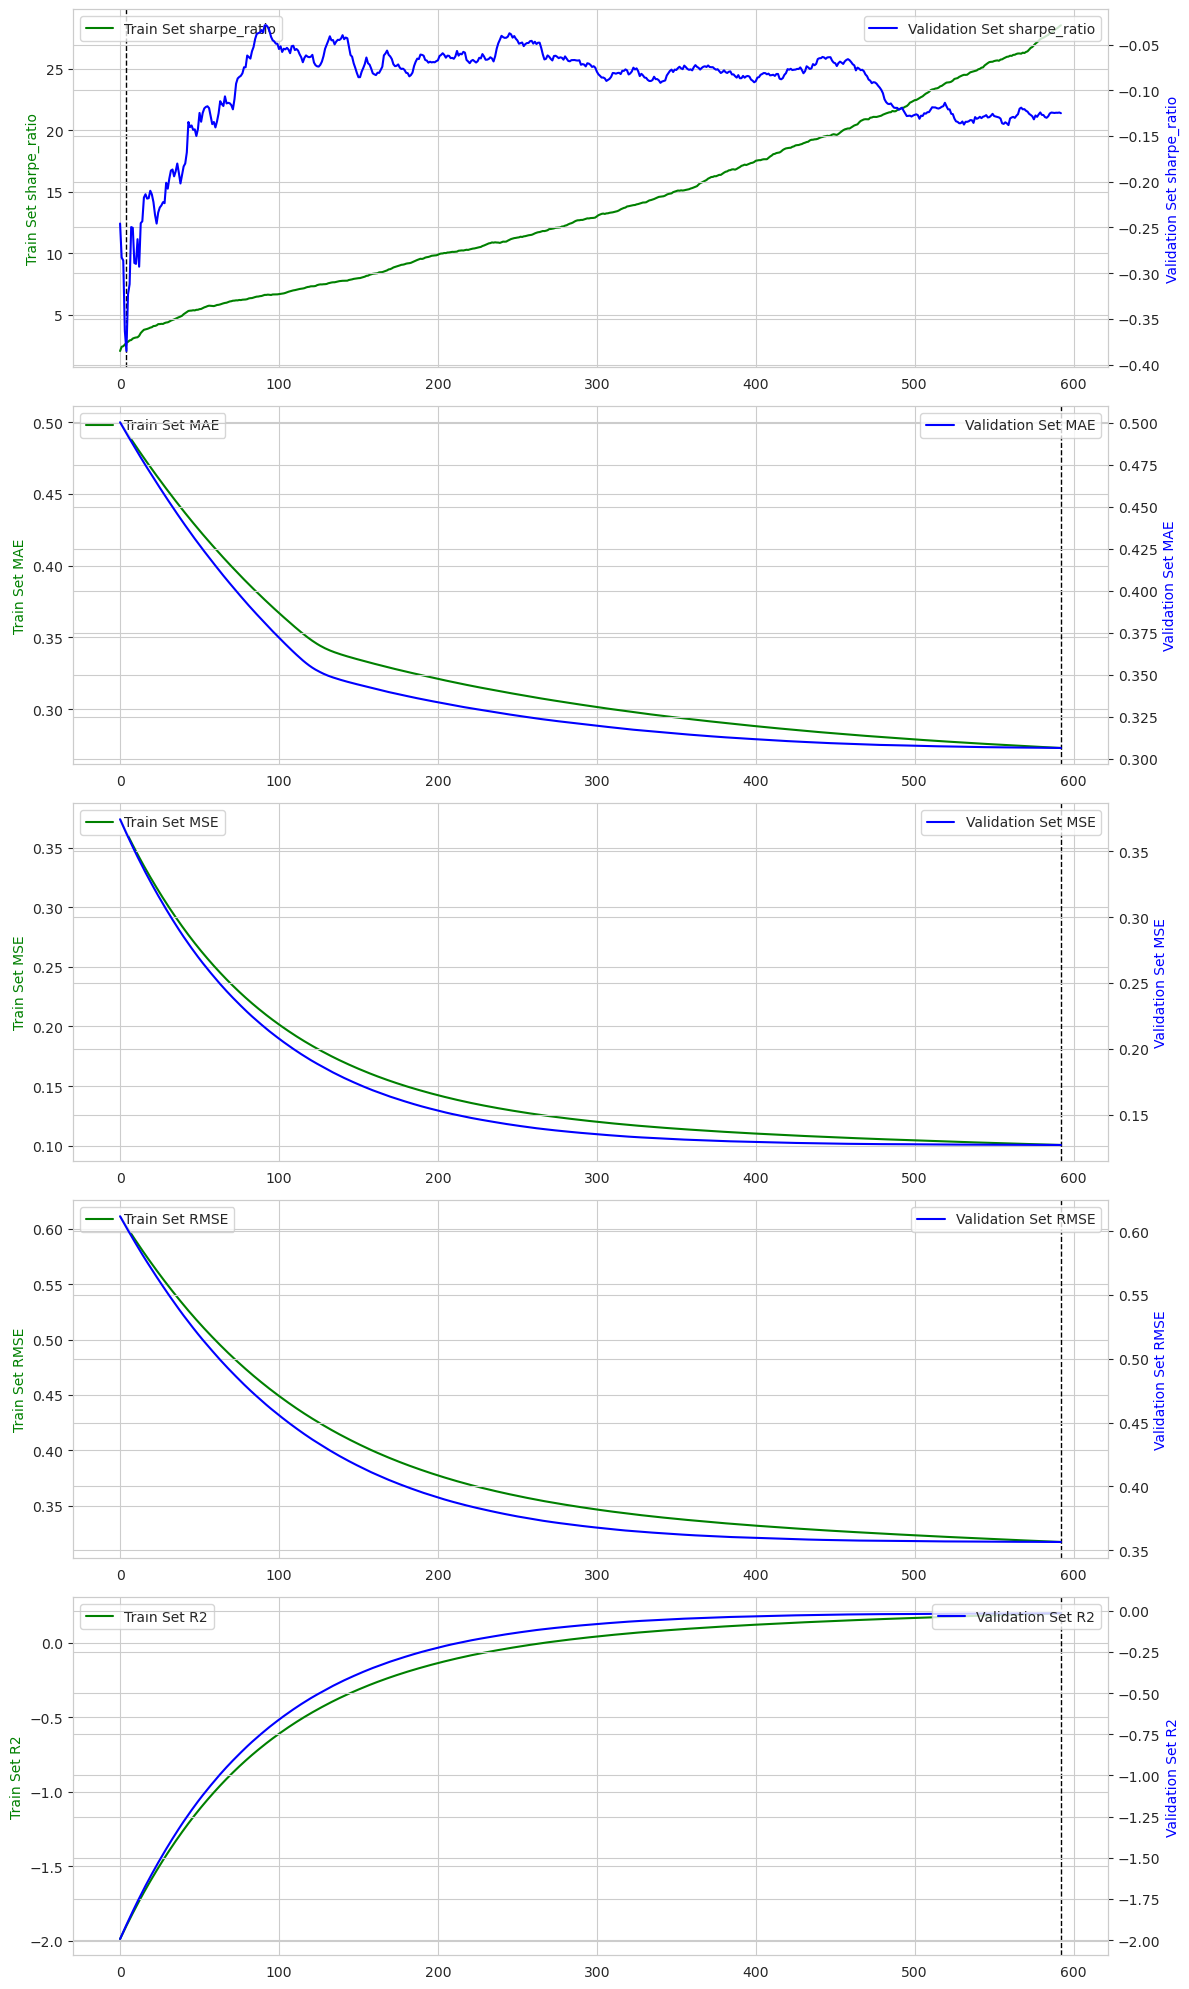

In [39]:
# Assuming evals_result contains MAE, MSE, RMSE, R2 as well
metrics = ['sharpe_ratio', 'MAE', 'MSE', 'RMSE', 'R2']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

for ax, metric in zip(axes, metrics):
    cv_result = pd.DataFrame({'Train Set': evals_result['train'][metric], 
                              'Validation Set': evals_result['valid_0'][metric]})
    
    ax1 = ax
    ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
    
    ax1.plot(cv_result.index, cv_result['Train Set'], 'g-', label=f'Train Set {metric}')
    ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-', label=f'Validation Set {metric}')
    
    ax1.set_ylabel(f'Train Set {metric}', color='g')
    ax2.set_ylabel(f'Validation Set {metric}', color='b')
    
    if metric != 'R2':
        ax1.axvline(cv_result['Validation Set'].idxmin(), c='k', ls='--', lw=1)
    else:
        ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [40]:
# # Extract cat_threshold from best_params
# cat_threshold = best_params.get('cat_threshold', 50)  # default to 50 if not in best_params

# Extract cat_threshold from best_params
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params


# Determine the categorical columns based on cat_threshold
categoricals = [col for col in dataset.columns if dataset[col].nunique() < cat_threshold 
                and dataset[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=dataset[features], label=dataset[label], 
                            categorical_feature=categoricals, free_raw_data=False)

best_params['force_col_wise'] = True
# Get the best iteration from your previous training
# Get the best iteration from your previous training
optimal_boosting_rounds = evals_result['valid_0']['sharpe_ratio'].index(max(evals_result['valid_0']['sharpe_ratio']))

if optimal_boosting_rounds == 0:
    optimal_boosting_rounds = 1
    print(optimal_boosting_rounds)

best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=optimal_boosting_rounds,  # Use the optimal number of rounds
                       feval=combined_eval_metrics,  # Updated feval
                       callbacks=[lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Total Bins 96061
[LightGBM] [Info] Number of data points in the train set: 117250, number of used features: 556
[LightGBM] [Info] Start training from score 0.501501


In [41]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

# Ensure that dataset_key doesn't contain invalid characters like slashes
clean_dataset_key = dataset_key.replace("/", "_")

# Formulate the clean save path
save_path = models / f"{top}{clean_dataset_key}_best_model_{target}.txt"

# Try saving again
best_model.save_model(save_path)
print(f"Model saved to {save_path}")

Model saved to models/250_data_YEAR_20200930_20220802_best_model_TARGET_ret_fwd_01d.txt


#### Test on unseen data

In [42]:
from pathlib import Path
import pandas as pd
from utils import rank_stocks_and_quantile

top = 250  # parameters -> papermill
UNSEEN_KEY = '/data/YEAR_20220803_20230803'
UNSEEN_STORE = Path(f'data/{top}_unseen_dataset.h5')
with pd.HDFStore(UNSEEN_STORE) as store:
    test_data = store[UNSEEN_KEY]
    test_data = rank_stocks_and_quantile(test_data, TARGET_col=target)
    # print(store.keys())

In [43]:
test_features = test_data[features]
test_labels = test_data[label]

model_path = f"/home/sayem/Desktop/Project/{save_path}"
# Load the model
best_model = lgb.Booster(model_file=model_path)

y_pred = best_model.predict(test_features)

preds = test_labels.reset_index(name=\
    'actual').assign(predicted=y_pred).set_index(['date', 'ticker'])

# Rename columns to add 'feature_' prefix
cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
new_col_names = ["FEATURE_" + col for col in cols_to_rename]
rename_dict = dict(zip(cols_to_rename, new_col_names))

test_data_renamed = test_data.rename(columns=rename_dict)

# Using the 'merge' method to join on MultiIndex levels 'date' and 'ticker'
preds = preds.reset_index().merge(test_data_renamed[new_col_names].reset_index(), 
                                  on=['ticker', 'date'], 
                                  how='left')

### Only select columns of interest
preds = preds[['date', 'ticker', 'actual', 'predicted'] \
    + new_col_names].set_index(['ticker', 'date'])


In [44]:
preds

,,actual,predicted,FEATURE_open,FEATURE_high,FEATURE_low,FEATURE_close,FEATURE_volume
ticker,date,,,,,,,
AA,2022-08-03 00:00:00+00:00,0.00,0.505347,48.448700,48.631500,47.298901,48.269600,4.403141e+06
AAL,2022-08-03 00:00:00+00:00,1.00,0.499576,14.200000,14.700000,14.150000,14.630000,2.836655e+07
AAPL,2022-08-03 00:00:00+00:00,0.50,0.505160,160.350998,166.082993,160.261002,165.625000,8.275915e+07
ABBV,2022-08-03 00:00:00+00:00,0.00,0.499261,140.292007,141.578995,139.227997,139.778000,5.529937e+06
ABT,2022-08-03 00:00:00+00:00,0.50,0.500379,108.598000,109.454002,107.762001,109.095001,3.884412e+06
...,...,...,...,...,...,...,...,...
WYNN,2023-08-03 00:00:00+00:00,0.00,0.503451,104.250000,106.849998,102.129997,105.610001,1.614293e+06
X,2023-08-03 00:00:00+00:00,0.50,0.497659,24.360001,24.865000,23.750000,24.260000,9.083687e+06
XOM,2023-08-03 00:00:00+00:00,0.75,0.500546,105.889999,107.879997,105.300003,107.120003,1.628311e+07


In [45]:
preds['predicted'].value_counts()
# print(value_counts)

0.443513    9
0.447946    9
0.447499    9
0.443979    6
0.444529    6
           ..
0.502162    1
0.498410    1
0.500268    1
0.502577    1
0.498622    1
Name: predicted, Length: 63886, dtype: int64

In [46]:
def daily_spearman(group):
    return spearmanr(group['actual'], group['predicted'])[0]

daily_correlations = preds.groupby('date').apply(daily_spearman)

In [47]:
daily_correlations.mean()

0.03413781328430692

In [48]:
daily_correlations.std()

0.11084037928181524

In [49]:
# Calculate the mean of daily correlations
mean_daily_correlation = daily_correlations.mean()

# Calculate Sharpe ratio for each date
fold_sharpe_ratio = papermill_fold_scores = daily_correlations / daily_correlations.std()

papermill_fold_scores_df = papermill_fold_scores.to_frame()
papermill_fold_scores_df.columns = papermill_fold_scores_df.columns.astype(str)
sb.glue("papermill_era_scores", papermill_fold_scores_df, display=True)

,0
date,
2022-08-03 00:00:00+00:00,-1.927264
2022-08-04 00:00:00+00:00,-0.761210
2022-08-05 00:00:00+00:00,0.509841
2022-08-08 00:00:00+00:00,1.720640
2022-08-09 00:00:00+00:00,0.006513
2022-08-10 00:00:00+00:00,-1.377447
2022-08-11 00:00:00+00:00,0.407408
2022-08-12 00:00:00+00:00,1.357321
2022-08-15 00:00:00+00:00,0.646269


In [50]:
# import matplotlib.pyplot as plt

# # Create a list of colors based on the sign of the Sharpe Ratios
# colors = ['blue' if value > 0 else 'red' for value in fold_sharpe_ratio]

# plt.figure(figsize=(12,6))
# fold_sharpe_ratio.plot(kind='bar', color=colors)
# plt.title('Daily Sharpe Ratios')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.axhline(y=0, color='black', linestyle='-')  # Here's where we add the horizontal line at y=0
# plt.xticks(rotation=45)  # rotates the x-axis labels for better visibility
# plt.show()

In [51]:
# plot_dir = Path("plots")
# plot_dir.mkdir(exist_ok=True)
# plot_path = plot_dir / f"sharpe_ratios_{key}.png"
# plt.savefig(plot_path)
# plt.close()

# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str, display=True)  # Glue the string

In [52]:
lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 3.456% (p-value: 0.00000000%)


0.034563578061508005

6.557205397732189e-19

In [53]:
# papermill_plot_path_str = str(plot_path)  # Convert to string
# sb.glue("papermill_plot_path", papermill_plot_path_str)  # Glue the string

# sb.glue("information_coefficient", information_coefficient)
# sb.glue("p_value", p_value)

In [54]:
# import pandas as pd
# import alphalens as al

# def generate_alphalens_tearsheet(df: pd.DataFrame, label_col: str, price_col: str) -> None:
#     """
#     Generate the Alphalens full tearsheet given the input dataframe, 
#     label column, and price data column.
#     """
#     # Extract the factor and trade_prices series
#     factor = df[label_col]
#     trade_prices = df[price_col]
    
#     # Remove duplicated indices from factor and trade_prices
#     factor = factor[~factor.index.duplicated(keep='first')]
#     trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
#     # Convert the trade_prices series into unstacked format
#     trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
#     # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
#     if isinstance(factor.index, pd.MultiIndex):
#         level_0 = factor.index.get_level_values(0)
#         if hasattr(level_0, 'tz') and level_0.tz is not None:
#             if level_0.tz != trade_prices_unstacked.index.tz:
#                 factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), \
#                     level=0, inplace=True)
#         factor = factor.swaplevel().sort_index()
#     else:
#         if hasattr(factor.index, 'tz') and factor.index.tz is not None:
#             if factor.index.tz != trade_prices_unstacked.index.tz:
#                 factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

#     # Create the factor_data dataframe with forward returns
#     alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
#         factor=factor,
#         prices=trade_prices_unstacked,
#         periods=[1, 5, 10],
#         max_loss=0.6
#     )
#     factor_returns = al.performance.factor_returns(alphalen_analysis)
#     sharpe_ratios = factor_returns.mean() / factor_returns.std()

#     print("\nSharpe Ratios:\n", sharpe_ratios)
#     alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
#     alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
#     return alphalen_analysis

# # target = 'actual'
# alphalens_analysis = generate_alphalens_tearsheet(preds, \
#     label_col='actual', price_col='FEATURE_close')

# import alphalens as al
# al.tears.create_full_tear_sheet(alphalens_analysis)